In [1]:
import pandas as pd
from tables import *
import numpy as np
from tqdm import tqdm_notebook as tqdm
import csv
from scipy import sparse
import pickle
import os

In [2]:
path = '/home/User1/data/self_citations/'

In [3]:
min_year = 1980
max_year = 2020
nb_years = max_year-min_year

In [4]:
disciplines = pd.read_csv(path+'liste_discipline.txt',encoding='latin_1',sep='\t')
list_disciplines = pd.unique(disciplines['EDiscipline'])
nb_disciplines = len(list_disciplines)

In [5]:
from matplotlib import pyplot as plt

In [6]:
types_cit = ['self','co','others']

In [7]:
authors_info = {}
with open(path+'model/authors_infos_model.csv','r') as f:
    reader = csv.reader(f,delimiter='\t')
    next(reader)
    for line in reader:
        authors_info[int(line[0])] = [line[1],int(line[2]),int(line[4])]

In [8]:
#Map to auth ID
with open(path+'authors_disc.p','rb') as f:
    authors_disc_idx = pickle.load(f)

In [9]:
#Keys:idx,values:authorID
for disc in list_disciplines:
    authors_disc_idx[disc] = {authors_disc_idx[disc][x]:x for x in authors_disc_idx[disc]}

In [10]:
disc_groups = {'Arts and Humanities':['Arts','Humanities'],
              'Natural Sciences and Engineering':['Biology','Physics','Mathematics','Engineering and Technology','Earth and Space','Chemistry'],
              'Social Sciences':['Social Sciences','Psychology','Professional Fields','Health'],
             'Health Sciences':['Biomedical Research','Clinical Medicine']}

nb_groups = len(disc_groups)
group_names = list(disc_groups.keys())


In [11]:
bins_nb_arts = np.concatenate([np.arange(1,50),np.arange(50,200,10),np.arange(200,1100,100),np.array([1500,2000])])
nb_bins = len(bins_nb_arts)

bins_lbl = bins_nb_arts.copy().astype(np.object)
bins_lbl[-3:] = ['1k','1.5k','2k']

min_bin = np.min(bins_nb_arts)
max_bin = np.max(bins_nb_arts)
bins_map = {}
for i in range(min_bin,max_bin+1):
    bins_map[i] = np.argmax(np.where(bins_nb_arts<=i)[0])

In [12]:
diff_pubs = np.diff(bins_nb_arts)
#diff_avg = np.concatenate([[1],diff_pubs])
diff_avg = diff_pubs.copy()
labels = []
for i in range(nb_bins-1):
    diff = diff_pubs[i]-1
    bin_val = bins_nb_arts[i+1]
    if diff == 0:
        labels.append(str(bin_val) + ' papers')
    else:
        labels.append('{}-{} papers'.format(str(bin_val),str(bin_val+diff)))

### With network and condensed disc

In [13]:
plt.figure(figsize=(15,15))
for i in tqdm(range(nb_groups)):
    group = group_names[i]   
    disc_group = disc_groups[group]
    arrays_refs = {}
    arrays_cits = {}

    type_cit = 'self'
    nb_pubs = []
    for disc in disc_group:
        load_cit = sparse.load_npz('{}/arrays/citations_{}_{}_array_norm_artPos.npz'.format(path,type_cit,disc)).todense()
        load_freqs = sparse.load_npz('{}/arrays/freq_bins_{}_{}_array_norm_artPos.npz'.format(path,type_cit,disc)).todense()

        idx_cits = load_cit.nonzero()
        avg_refs = np.zeros(load_cit.shape)
        avg_refs[idx_cits] = load_cit[idx_cits]/load_freqs[idx_cits]
        if type_cit in arrays_cits: 
            arrays_cits[type_cit] = np.concatenate([arrays_cits[type_cit],load_cit],axis=0)
            arrays_refs[type_cit] = np.concatenate([arrays_refs[type_cit],avg_refs],axis=0)
        else:
            arrays_cits[type_cit] = load_cit
            arrays_refs[type_cit] = avg_refs

    self_cits_cumul = np.cumsum(arrays_cits[type_cit],axis=1)                  
    active_cits = np.zeros(arrays_cits[type_cit].shape)
    last_nz_cits = self_cits_cumul.argmax(1)
    nb_cits = np.sum(arrays_cits[type_cit],axis=1)
    for j in range(active_cits.shape[0]):
        if nb_cits[j] > 0:
            last_idx = np.asarray(last_nz_cits[j])[0][0]
            self_cits_cumul[j,last_idx+1:] = 0
            active_cits[j,:last_idx+1] = 1
    nb_active_cits = np.sum(active_cits,axis=0)
    stats_cits = np.divide(np.squeeze(np.asarray(np.sum(self_cits_cumul,axis=0))),nb_active_cits)

    # active_refs = np.zeros(arrays_refs[type_cit].shape)
    # last_nz_refs = (arrays_refs[type_cit]!=0).cumsum(1).argmax(1)
    # nb_refs = np.sum(arrays_refs[type_cit],axis=1)
    # for j in range(active_refs.shape[0]):
    #     if nb_refs[j] > 0:
    #         last_idx = np.asarray(last_nz_refs[j])
    #         active_refs[j,:last_idx+1] = 1
    # nb_active_refs = np.sum(active_refs,axis=0)
    # stats_refs= np.divide(np.squeeze(np.asarray(np.sum(arrays_refs[type_cit],axis=0))),nb_active_refs)    

    active_cits = np.zeros(arrays_cits[type_cit].shape)
    last_nz_cits = (arrays_cits[type_cit]!=0).cumsum(1).argmax(1)
    nb_cits = np.sum(arrays_cits[type_cit],axis=1)
    for j in range(active_cits.shape[0]):
        if nb_cits[j] > 0:
            last_idx = np.asarray(last_nz_cits[j])[0][0]
            active_cits[j,:last_idx+1] = 1
    nb_active_cits = np.sum(active_cits,axis=0)
    stats_refs= np.divide(np.squeeze(np.asarray(np.sum(arrays_cits[type_cit],axis=0))),nb_active_cits)    



    plt.subplot(2,2,i+1)
    plt.plot(stats_cits[:49],'r',label='# self citations (cumul.)',linewidth=2)
    plt.ylabel('# citations',fontsize=20)
    plt.legend(loc='upper left')
    plt.tick_params(labelsize=18)
    plt.xlabel('Publication #',fontsize=20)
    plt.twinx()
    plt.plot(stats_refs[:49],'g',label='Avg. # self references',linewidth=2)
    plt.legend(loc='upper right')
    plt.ylabel('# references',fontsize=20)
    plt.title(group,fontsize=20)
    #plt.xticks(np.arange(len(bins_nb_arts)), bins_nb_arts)
    plt.tick_params(labelsize=18)
#plt.show()
out_path = path+'results/nb_self_cits_nbArts/'
#plt.show()
if not os.path.exists(out_path):
    os.makedirs(out_path)
plt.savefig(out_path + '1_to_50.png')
plt.savefig(out_path + '1_to_50.svg')

plt.close()


/home/User1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


A Jupyter Widget

/home/User1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/home/User1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in true_divide
/home/User1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/home/User1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in true_divide


### With bins

In [13]:
for i in tqdm(range(nb_groups)):
    group = group_names[i]   
    disc_group = disc_groups[group]
    arrays_refs = {}
    arrays_cits = {}

    type_cit = 'self'
    nb_pubs = []
    for disc in disc_group:
        load_cit = sparse.load_npz('{}/arrays/citations_{}_{}_array_norm_artPos.npz'.format(path,type_cit,disc)).todense()
        load_freqs = sparse.load_npz('{}/arrays/freq_bins_{}_{}_array_norm_artPos.npz'.format(path,type_cit,disc)).todense()
        nb_auts = load_cit.shape[0]
        idx_cits = load_cit.nonzero()
        avg_refs = np.zeros(load_cit.shape)
        avg_refs[idx_cits] = load_cit[idx_cits]/load_freqs[idx_cits]
        load_nb_pubs = np.array([authors_info[authors_disc_idx[disc][x]][2] for x in range(nb_auts)])
        nb_pubs = np.concatenate([nb_pubs,load_nb_pubs],axis=0)
        if type_cit in arrays_cits: 
            arrays_cits[type_cit] = np.concatenate([arrays_cits[type_cit],load_cit],axis=0)
            arrays_refs[type_cit] = np.concatenate([arrays_refs[type_cit],avg_refs],axis=0)
        else:
            arrays_cits[type_cit] = load_cit
            arrays_refs[type_cit] = avg_refs

    self_cits_cumul = np.cumsum(arrays_cits[type_cit],axis=1)                  
    active_cits = np.zeros(arrays_cits[type_cit].shape)
    last_nz_cits = self_cits_cumul.argmax(1)
    nb_cits = np.sum(arrays_cits[type_cit],axis=1)
#     for j in range(active_cits.shape[0]):
#         if nb_cits[j] > 0:
#             last_idx = np.asarray(last_nz_cits[j])[0][0]
#             self_cits_cumul[j,last_idx+1:] = 0
#             active_cits[j,:last_idx+1] = 1
#             nb_pubs_aut = nb_pubs[j]
#             left_val = bins_nb_arts[last_idx]
    self_refs = np.full(arrays_cits[type_cit].shape,np.nan)          
    for j in range(active_cits.shape[0]):
        last_idx = np.asarray(last_nz_cits[j])[0][0]
        sum_cits = self_cits_cumul[j,-1]
        self_cits_cumul[j,last_idx+1:] = 0
        active_cits[j,:last_idx+1] = 1
        nb_pubs_aut = nb_pubs[j]
        left_val = bins_nb_arts[last_idx]
        if sum_cits>0:
            refs = np.array(arrays_cits[type_cit][j,:]).ravel()
            if last_idx>0:
                refs[:last_idx] = np.divide(refs[:last_idx],diff_avg[:last_idx])
                diff_last = nb_pubs_aut-left_val
                if diff_last > 1:
                    refs[last_idx] = refs[last_idx]/diff_last        
            self_refs[j,:last_idx+1] = refs[:last_idx+1]
        
    
    nb_active_cits = np.sum(active_cits,axis=0)
    stats_cits = np.divide(np.squeeze(np.asarray(np.sum(self_cits_cumul,axis=0))),nb_active_cits)

    # active_refs = np.zeros(arrays_refs[type_cit].shape)
    # last_nz_refs = (arrays_refs[type_cit]!=0).cumsum(1).argmax(1)
    # nb_refs = np.sum(arrays_refs[type_cit],axis=1)
    # for j in range(active_refs.shape[0]):
    #     if nb_refs[j] > 0:
    #         last_idx = np.asarray(last_nz_refs[j])
    #         active_refs[j,:last_idx+1] = 1
    # nb_active_refs = np.sum(active_refs,axis=0)
    # stats_refs= np.divide(np.squeeze(np.asarray(np.sum(arrays_refs[type_cit],axis=0))),nb_active_refs)    

#     active_cits = np.zeros(arrays_cits[type_cit].shape)
#     last_nz_cits = (arrays_cits[type_cit]!=0).cumsum(1).argmax(1)
#     nb_cits = np.sum(arrays_cits[type_cit],axis=1)
#     for j in range(active_cits.shape[0]):
#         if nb_cits[j] > 0:
#             last_idx = np.asarray(last_nz_cits[j])[0][0]
#             active_cits[j,:last_idx+1] = 1
#     nb_active_cits = np.sum(active_cits,axis=0)
    #stats_refs= np.divide(np.squeeze(np.asarray(np.sum(arrays_cits[type_cit],axis=0))),nb_active_cits)  
    stats_refs = np.nanmean(self_refs,axis=0)
    plt.figure(figsize=(12,7.5))
    for k in range(2):
        ax = plt.subplot(2,1,k+1)
        if k == 0:
            s = 0
            e = 49
            plt.title(group,fontsize=14)
            xticks = np.array([0]+list(range(4,49,5)))
            xticks_lbl = bins_lbl[xticks]
        else:
            s = 49
            e = nb_bins-1
            xticks = np.arange(0,nb_bins-s-1)
            xticks_lbl = bins_lbl[np.arange(s,nb_bins-1)]


        ax.plot(stats_cits[s:e],'r',label='# self citations (cumul.)',linewidth=2)
        ax.set_ylabel('# citations',fontsize=15)
        if k == 0 :
            ax.legend(loc='upper left')
        ax.tick_params(labelsize=12)
        ax.set_xlabel('Publication #',fontsize=15)

        plt.xticks(xticks,xticks_lbl)

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        # Only show ticks on the left and bottom spines
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        if k == 0 :
            ax.legend(loc='upper left')
        ax2 = ax.twinx()
        ax2.plot(stats_refs[s:e],'g',label='Avg. # self references',linewidth=2)
        if k == 0 :
            ax.legend(loc='upper right')
        ax2.set_ylabel('# references',fontsize=20)



    #     ax2.spines['right'].set_visible(False)
    #     ax2.spines['top'].set_visible(False)

    #     # Only show ticks on the left and bottom spines
    #     ax2.yaxis.set_ticks_position('left')
    #     ax2.xaxis.set_ticks_position('bottom')
    #     #plt.xticks(np.arange(len(bins_nb_arts)), bins_nb_arts)


    plt.tick_params(labelsize=12)
    #plt.show()
    out_path = path+'results/nb_self_cits_nbArts/'
    #plt.show()
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    plt.savefig(out_path + '{}_all.png'.format(group))
    plt.savefig(out_path + '{}_all.svg'.format(group))

    plt.close()


/home/User1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


A Jupyter Widget

/home/User1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide
/home/User1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:76: RuntimeWarning: Mean of empty slice
/home/User1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide
/home/User1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:76: RuntimeWarning: Mean of empty slice


In [15]:
group_names

['Arts and Humanities',
 'Natural Sciences and Engineering',
 'Social Sciences',
 'Health Sciences']

/home/User1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in true_divide
/home/User1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: Mean of empty slice


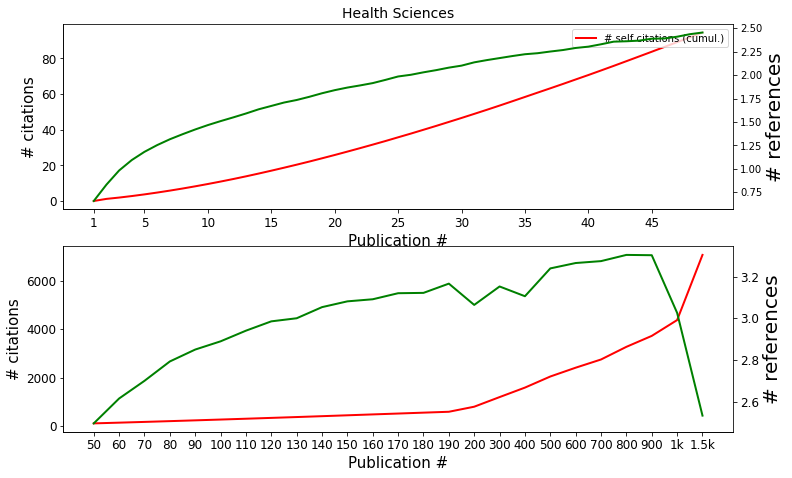

In [16]:
group = group_names[3]   
disc_group = disc_groups[group]
arrays_refs = {}
arrays_cits = {}

type_cit = 'self'
nb_pubs = []
for disc in disc_group:
    load_cit = sparse.load_npz('{}/arrays/citations_{}_{}_array_norm_artPos.npz'.format(path,type_cit,disc)).todense()
    load_freqs = sparse.load_npz('{}/arrays/freq_bins_{}_{}_array_norm_artPos.npz'.format(path,type_cit,disc)).todense()
    nb_auts = load_cit.shape[0]
    idx_cits = load_cit.nonzero()
    avg_refs = np.zeros(load_cit.shape)
    avg_refs[idx_cits] = load_cit[idx_cits]/load_freqs[idx_cits]
    load_nb_pubs = np.array([authors_info[authors_disc_idx[disc][x]][2] for x in range(nb_auts)])
    nb_pubs = np.concatenate([nb_pubs,load_nb_pubs],axis=0)
    if type_cit in arrays_cits: 
        arrays_cits[type_cit] = np.concatenate([arrays_cits[type_cit],load_cit],axis=0)
        arrays_refs[type_cit] = np.concatenate([arrays_refs[type_cit],avg_refs],axis=0)
    else:
        arrays_cits[type_cit] = load_cit
        arrays_refs[type_cit] = avg_refs

self_cits_cumul = np.cumsum(arrays_cits[type_cit],axis=1)                  
active_cits = np.zeros(arrays_cits[type_cit].shape)
last_nz_cits = self_cits_cumul.argmax(1)
nb_cits = np.sum(arrays_cits[type_cit],axis=1)
#     for j in range(active_cits.shape[0]):
#         if nb_cits[j] > 0:
#             last_idx = np.asarray(last_nz_cits[j])[0][0]
#             self_cits_cumul[j,last_idx+1:] = 0
#             active_cits[j,:last_idx+1] = 1
#             nb_pubs_aut = nb_pubs[j]
#             left_val = bins_nb_arts[last_idx]
self_refs = np.full(arrays_cits[type_cit].shape,np.nan)          
for j in range(active_cits.shape[0]):
    last_idx = np.asarray(last_nz_cits[j])[0][0]
    sum_cits = self_cits_cumul[j,-1]
    self_cits_cumul[j,last_idx+1:] = 0
    active_cits[j,:last_idx+1] = 1
    nb_pubs_aut = nb_pubs[j]
    left_val = bins_nb_arts[last_idx]
    if sum_cits>0:
        refs = np.array(arrays_cits[type_cit][j,:]).ravel()
        if last_idx>0:
            refs[:last_idx] = np.divide(refs[:last_idx],diff_avg[:last_idx])
            diff_last = nb_pubs_aut-left_val
            if diff_last > 1:
                refs[last_idx] = refs[last_idx]/diff_last        
        self_refs[j,:last_idx+1] = refs[:last_idx+1]


nb_active_cits = np.sum(active_cits,axis=0)
stats_cits = np.divide(np.squeeze(np.asarray(np.sum(self_cits_cumul,axis=0))),nb_active_cits)

# active_refs = np.zeros(arrays_refs[type_cit].shape)
# last_nz_refs = (arrays_refs[type_cit]!=0).cumsum(1).argmax(1)
# nb_refs = np.sum(arrays_refs[type_cit],axis=1)
# for j in range(active_refs.shape[0]):
#     if nb_refs[j] > 0:
#         last_idx = np.asarray(last_nz_refs[j])
#         active_refs[j,:last_idx+1] = 1
# nb_active_refs = np.sum(active_refs,axis=0)
# stats_refs= np.divide(np.squeeze(np.asarray(np.sum(arrays_refs[type_cit],axis=0))),nb_active_refs)    

#     active_cits = np.zeros(arrays_cits[type_cit].shape)
#     last_nz_cits = (arrays_cits[type_cit]!=0).cumsum(1).argmax(1)
#     nb_cits = np.sum(arrays_cits[type_cit],axis=1)
#     for j in range(active_cits.shape[0]):
#         if nb_cits[j] > 0:
#             last_idx = np.asarray(last_nz_cits[j])[0][0]
#             active_cits[j,:last_idx+1] = 1
#     nb_active_cits = np.sum(active_cits,axis=0)
#stats_refs= np.divide(np.squeeze(np.asarray(np.sum(arrays_cits[type_cit],axis=0))),nb_active_cits)  
stats_refs = np.nanmean(self_refs,axis=0)
plt.figure(figsize=(12,7.5))
for k in range(2):
    ax = plt.subplot(2,1,k+1)
    if k == 0:
        s = 0
        e = 49
        plt.title(group,fontsize=14)
        xticks = np.array([0]+list(range(4,49,5)))
        xticks_lbl = bins_lbl[xticks]
    else:
        s = 49
        e = nb_bins-1
        xticks = np.arange(0,nb_bins-s-1)
        xticks_lbl = bins_lbl[np.arange(s,nb_bins-1)]

    ax.plot(stats_cits[s:e],'r',label='# self citations (cumul.)',linewidth=2)
    ax.set_ylabel('# citations',fontsize=15)
    if k == 0 :
        ax.legend(loc='upper left')
    ax.tick_params(labelsize=12)
    ax.set_xlabel('Publication #',fontsize=15)

    plt.xticks(xticks,xticks_lbl)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    if k == 0 :
        ax.legend(loc='upper left')
    ax2 = ax.twinx()
    ax2.plot(stats_refs[s:e],'g',label='Avg. # self references',linewidth=2)
    if k == 0 :
        ax.legend(loc='upper right')
    ax2.set_ylabel('# references',fontsize=20)



#     ax2.spines['right'].set_visible(False)
#     ax2.spines['top'].set_visible(False)

#     # Only show ticks on the left and bottom spines
#     ax2.yaxis.set_ticks_position('left')
#     ax2.xaxis.set_ticks_position('bottom')
#     #plt.xticks(np.arange(len(bins_nb_arts)), bins_nb_arts)


plt.tick_params(labelsize=12)
plt.show()

In [13]:
group = group_names[1]   
disc_group = disc_groups[group]
arrays_refs = {}
arrays_cits = {}

type_cit = 'self'
nb_pubs = []
for disc in disc_group:
    load_cit = sparse.load_npz('{}/arrays/citations_{}_{}_array_norm_artPos.npz'.format(path,type_cit,disc)).todense()
    load_freqs = sparse.load_npz('{}/arrays/freq_bins_{}_{}_array_norm_artPos.npz'.format(path,type_cit,disc)).todense()
    nb_auts = load_cit.shape[0]
    idx_cits = load_cit.nonzero()
    avg_refs = np.zeros(load_cit.shape)
    avg_refs[idx_cits] = load_cit[idx_cits]/load_freqs[idx_cits]
    load_nb_pubs = np.array([authors_info[authors_disc_idx[disc][x]][2] for x in range(nb_auts)])
    nb_pubs = np.concatenate([nb_pubs,load_nb_pubs],axis=0)
    if type_cit in arrays_cits: 
        arrays_cits[type_cit] = np.concatenate([arrays_cits[type_cit],load_cit],axis=0)
        arrays_refs[type_cit] = np.concatenate([arrays_refs[type_cit],avg_refs],axis=0)
    else:
        arrays_cits[type_cit] = load_cit
        arrays_refs[type_cit] = avg_refs

self_cits_cumul = np.cumsum(arrays_cits[type_cit],axis=1)                  
active_cits = np.zeros(arrays_cits[type_cit].shape)
last_nz_cits = self_cits_cumul.argmax(1)
nb_cits = np.sum(arrays_cits[type_cit],axis=1)
#     for j in range(active_cits.shape[0]):
#         if nb_cits[j] > 0:
#             last_idx = np.asarray(last_nz_cits[j])[0][0]
#             self_cits_cumul[j,last_idx+1:] = 0
#             active_cits[j,:last_idx+1] = 1
#             nb_pubs_aut = nb_pubs[j]
#             left_val = bins_nb_arts[last_idx]
self_refs = np.full(arrays_cits[type_cit].shape,np.nan)          
for j in range(active_cits.shape[0]):
    last_idx = np.asarray(last_nz_cits[j])[0][0]
    sum_cits = self_cits_cumul[j,-1]
    self_cits_cumul[j,last_idx+1:] = 0
    active_cits[j,:last_idx+1] = 1
    nb_pubs_aut = nb_pubs[j]
    left_val = bins_nb_arts[last_idx]
    if sum_cits>0:
        refs = np.array(arrays_cits[type_cit][j,:]).ravel()
        if last_idx>0:
            refs[:last_idx] = np.divide(refs[:last_idx],diff_avg[:last_idx])
            diff_last = nb_pubs_aut-left_val
            if diff_last > 1:
                refs[last_idx] = refs[last_idx]/diff_last        
#         more_ten = np.where(refs>=20)[0]
#         if len(more_ten)> 0:
#             break
        self_refs[j,:last_idx+1] = refs[:last_idx+1]
        if last_idx+1 == nb_bins:
            break
        

nb_active_cits = np.sum(active_cits,axis=0)
stats_cits = np.divide(np.squeeze(np.asarray(np.sum(self_cits_cumul,axis=0))),nb_active_cits)

# active_refs = np.zeros(arrays_refs[type_cit].shape)
# last_nz_refs = (arrays_refs[type_cit]!=0).cumsum(1).argmax(1)
# nb_refs = np.sum(arrays_refs[type_cit],axis=1)
# for j in range(active_refs.shape[0]):
#     if nb_refs[j] > 0:
#         last_idx = np.asarray(last_nz_refs[j])
#         active_refs[j,:last_idx+1] = 1
# nb_active_refs = np.sum(active_refs,axis=0)
# stats_refs= np.divide(np.squeeze(np.asarray(np.sum(arrays_refs[type_cit],axis=0))),nb_active_refs)    

#     active_cits = np.zeros(arrays_cits[type_cit].shape)
#     last_nz_cits = (arrays_cits[type_cit]!=0).cumsum(1).argmax(1)
#     nb_cits = np.sum(arrays_cits[type_cit],axis=1)
#     for j in range(active_cits.shape[0]):
#         if nb_cits[j] > 0:
#             last_idx = np.asarray(last_nz_cits[j])[0][0]
#             active_cits[j,:last_idx+1] = 1
#     nb_active_cits = np.sum(active_cits,axis=0)
#stats_refs= np.divide(np.squeeze(np.asarray(np.sum(arrays_cits[type_cit],axis=0))),nb_active_cits)  
stats_refs = np.nanmean(self_refs,axis=0)


In [20]:
nb_pubs_aut


3181.0

In [19]:
np.array(arrays_cits[type_cit][j,:]).ravel()

array([0.00000000e+00, 2.47866482e+00, 2.47866482e+00, 0.00000000e+00,
       4.95732963e+00, 4.72018977e+00, 4.72018977e+00, 0.00000000e+00,
       0.00000000e+00, 2.36009488e+00, 4.72018977e+00, 9.44037954e+00,
       1.18004744e+01, 6.89193932e+00, 2.29731311e+00, 6.89193932e+00,
       9.18925243e+00, 4.59462621e+00, 9.18925243e+00, 2.29731311e+00,
       2.29731311e+00, 4.59462621e+00, 4.59462621e+00, 0.00000000e+00,
       0.00000000e+00, 2.24042048e+00, 8.96168191e+00, 4.48084095e+00,
       6.72126143e+00, 8.96168191e+00, 1.56829433e+01, 4.48084095e+00,
       4.37489400e+00, 4.25611879e+00, 0.00000000e+00, 4.25611879e+00,
       2.05830887e+00, 0.00000000e+00, 2.05830887e+00, 4.11661774e+00,
       4.11661774e+00, 3.97942498e+00, 1.98971249e+00, 1.98971249e+00,
       7.95884997e+00, 1.98971249e+00, 1.98971249e+00, 3.97942498e+00,
       7.95884997e+00, 3.18353999e+01, 4.65196509e+01, 5.41421058e+01,
       9.87201884e+01, 5.60798567e+01, 4.57560550e+01, 5.46141184e+01,
      

In [14]:
refs = np.array(arrays_cits[type_cit][j,:]).ravel()
if last_idx>0:
    refs[:last_idx] = np.divide(refs[:last_idx],diff_avg[:last_idx])
    diff_last = nb_pubs_aut-left_val
    if diff_last > 1:
        refs[last_idx] = refs[last_idx]/diff_last        
#         more_ten = np.where(refs>=20)[0]
#         if len(more_ten)> 0:
#             break
self_refs[j,:last_idx+1] = refs[:last_idx+1]

array([0.00000000e+00, 2.47866482e+00, 2.47866482e+00, 0.00000000e+00,
       4.95732963e+00, 4.72018977e+00, 4.72018977e+00, 0.00000000e+00,
       0.00000000e+00, 2.36009488e+00, 4.72018977e+00, 9.44037954e+00,
       1.18004744e+01, 6.89193932e+00, 2.29731311e+00, 6.89193932e+00,
       9.18925243e+00, 4.59462621e+00, 9.18925243e+00, 2.29731311e+00,
       2.29731311e+00, 4.59462621e+00, 4.59462621e+00, 0.00000000e+00,
       0.00000000e+00, 2.24042048e+00, 8.96168191e+00, 4.48084095e+00,
       6.72126143e+00, 8.96168191e+00, 1.56829433e+01, 4.48084095e+00,
       4.37489400e+00, 4.25611879e+00, 0.00000000e+00, 4.25611879e+00,
       2.05830887e+00, 0.00000000e+00, 2.05830887e+00, 4.11661774e+00,
       4.11661774e+00, 3.97942498e+00, 1.98971249e+00, 1.98971249e+00,
       7.95884997e+00, 1.98971249e+00, 1.98971249e+00, 3.97942498e+00,
       7.95884997e+00, 3.18353999e+00, 4.65196509e+00, 5.41421058e+00,
       9.87201884e+00, 5.60798567e+00, 4.57560550e+00, 5.46141184e+00,
      

In [15]:
refs = np.array(arrays_cits[type_cit][j,:]).ravel()
if last_idx>0:
    refs[:last_idx] = np.divide(refs[:last_idx],diff_avg[:last_idx])
    diff_last = nb_pubs_aut-left_val

In [18]:
nb_bins

75

In [122]:
refs = np.array(arrays_cits[type_cit][j,:]).ravel()
if last_idx>0:
    refs[:last_idx] = np.divide(refs[:last_idx],diff_avg[:last_idx])

In [126]:
refs = np.array(arrays_cits[type_cit][j,:]).ravel()
if last_idx>0:
    refs[:last_idx] = np.divide(refs[:last_idx],diff_avg[:last_idx])
    diff_last = nb_pubs_aut-left_val
    if diff_last > 1:
        refs[last_idx] = refs[last_idx]/diff_last  

In [125]:
refs[last_idx]/diff_last    

6.840141410062376

In [124]:
refs[last_idx]

540.3711713949277

In [110]:
nb_pubs_aut

279.0

In [107]:
diff_avg[:last_idx+1]

array([  1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,  10,  10,  10,  10,
        10,  10,  10,  10,  10,  10,  10,  10,  10,  10,  10, 100, 100])

In [93]:
refs

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  2.70425983,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  2.70425983,  0.        ,
        2.70425983,  0.        ,  2.605434  ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        2.605434  ,  5.13341557,  2.56670779,  0.        ,  0.        ,
        0.        ,  7.70012336,  0.        ,  0.        ,  2.52922585,
        0.        ,  0.        ,  7.58767754, 10.11690339,  0.        ,
        5.0584517 ,  2.52922585,  0.        ,  2.52922585,  5.00789067,
        1.98293185,  4.21373019,  2.59610437,  5.17337421,  2.05051401,
        2.68850457,  5.23205651,  9.78907321,  7.02615036,  3.45486677,
        3.85145634,  2.62743547,  2.22365109,  3.45889416, 36.49161636,
        2.14536217,  0.        ,  0.        ,  0.        ,  0.  

In [108]:
self_cits_cumul[j,:]

matrix([[   0.        ,    0.        ,    0.        ,    0.        ,
            2.605434  ,    2.605434  ,   10.30555736,   15.43897294,
           15.43897294,   23.1390963 ,   35.78522554,   38.31445139,
           45.75044584,   45.75044584,   63.10109955,   73.01575882,
           85.4090829 ,   85.4090829 ,  107.71706625,  107.71706625,
          107.71706625,  117.15744579,  119.51754067,  131.31801509,
          136.03820486,  154.41670972,  172.79521458,  172.79521458,
          172.79521458,  179.6871539 ,  179.6871539 ,  190.88925628,
          197.61051771,  211.05304058,  226.36516956,  250.42708655,
          256.98942754,  265.73921553,  285.42623852,  300.7383675 ,
          300.7383675 ,  322.01896144,  326.27508023,  330.39169796,
          342.74155117,  344.79986004,  367.44125759,  396.25758174,
          406.54912608,  496.26504063,  608.5400372 ,  692.67254894,
          796.34727384,  939.80832336, 1058.83929939, 1115.66355125,
         1220.93455718, 1281.82489

In [114]:
bins_nb_arts[:last_idx]

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  60,  70,
        80,  90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190])

No handles with labels found to put in legend.


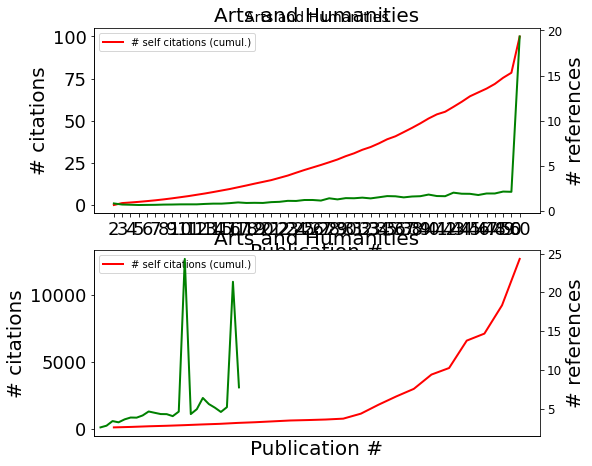

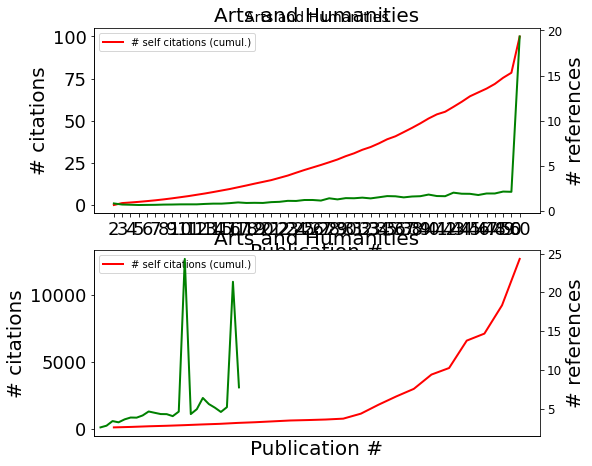

In [65]:
plt.figure(figsize=(8,7.5))
for k in range(2):
    ax = plt.subplot(2,1,k+1)
    if k == 0:
        s = 0
        e = 50
        plt.title(group,fontsize=14)
        plt.legend(loc='upper right')
    else:
        s = 50
        e = nb_bins


    plt.plot(stats_cits[s:e],'r',label='# self citations (cumul.)',linewidth=2)
    plt.ylabel('# citations',fontsize=20)
    plt.legend(loc='upper left')
    plt.tick_params(labelsize=18)
    plt.xlabel('Publication #',fontsize=20)
    plt.twinx()
    plt.plot(stats_refs[s:e],'g',label='Avg. # self references',linewidth=2)
    plt.ylabel('# references',fontsize=20)
    plt.title(group,fontsize=20)
    #plt.xticks(np.arange(len(bins_nb_arts)), bins_nb_arts)
    plt.tick_params(labelsize=18)

    plt.xticks(np.arange(nb_bins-1)[s:e],bins_lbl[1:][s:e])
    plt.xlabel('# publications',fontsize=12)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    plt.tick_params(labelsize=12)


plt.show()

In [57]:
refs[:last_idx] = np.divide(refs[:last_idx],diff_avg[:last_idx])

2

In [60]:
refs[:last_idx]

array([[0.        , 3.64094123, 1.17829239, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

In [59]:
diff_avg[:last_idx]

array([1, 1])

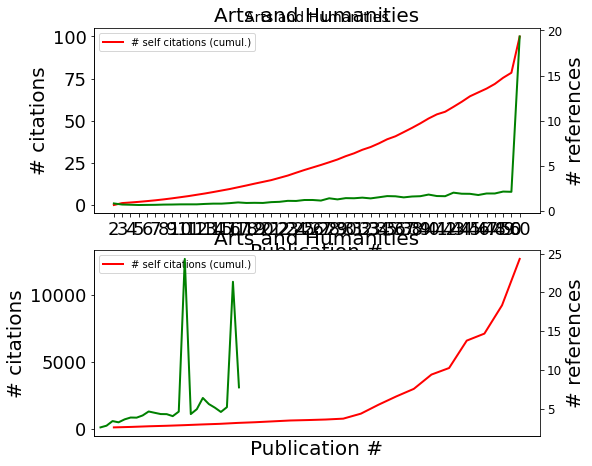

In [63]:
plt.show()

In [19]:
group = group_names[0]   
disc_group = disc_groups[group]
arrays_refs = {}
arrays_cits = {}

type_cit = 'self'
nb_pubs = []
for disc in disc_group:
    load_cit = sparse.load_npz('{}/arrays/citations_{}_{}_array_norm_artPos.npz'.format(path,type_cit,disc)).todense()
    load_freqs = sparse.load_npz('{}/arrays/freq_bins_{}_{}_array_norm_artPos.npz'.format(path,type_cit,disc)).todense()
    nb_auts = load_cit.shape[0]
    idx_cits = load_cit.nonzero()
    avg_refs = np.zeros(load_cit.shape)
    avg_refs[idx_cits] = load_cit[idx_cits]/load_freqs[idx_cits]
    load_nb_pubs = np.array([authors_info[authors_disc_idx[disc][x]][2] for x in range(nb_auts)])
    nb_pubs = np.concatenate([nb_pubs,load_nb_pubs],axis=0)
    if type_cit in arrays_cits: 
        arrays_cits[type_cit] = np.concatenate([arrays_cits[type_cit],load_cit],axis=0)
        arrays_refs[type_cit] = np.concatenate([arrays_refs[type_cit],avg_refs],axis=0)
    else:
        arrays_cits[type_cit] = load_cit
        arrays_refs[type_cit] = avg_refs

self_cits_cumul = np.cumsum(arrays_cits[type_cit],axis=1)                  
active_cits = np.zeros(arrays_cits[type_cit].shape)
last_nz_cits = self_cits_cumul.argmax(1)
nb_cits = np.sum(arrays_cits[type_cit],axis=1)
for j in range(active_cits.shape[0]):
    if nb_cits[j] > 0:
        last_idx = np.asarray(last_nz_cits[j])[0][0]
        self_cits_cumul[j,last_idx+1:] = 0
        active_cits[j,:last_idx+1] = 1
nb_active_cits = np.sum(active_cits,axis=0)
stats_cits = np.divide(np.squeeze(np.asarray(np.sum(self_cits_cumul,axis=0))),nb_active_cits)

active_refs = np.zeros(arrays_refs[type_cit].shape)
last_nz_refs = (arrays_refs[type_cit]!=0).cumsum(1).argmax(1)
nb_refs = np.sum(arrays_refs[type_cit],axis=1) 
for j in range(active_refs.shape[0]):
    if nb_refs[j] > 0:
        last_idx = np.asarray(last_nz_refs[j])
        active_refs[j,:last_idx+1] = 1
nb_active_refs = np.sum(active_refs,axis=0)
stats_refs= np.divide(np.squeeze(np.asarray(np.sum(arrays_refs[type_cit],axis=0))),nb_active_refs)    

# active_cits = np.zeros(arrays_cits[type_cit].shape)
# last_nz_cits = (arrays_cits[type_cit]!=0).cumsum(1).argmax(1)
# nb_cits = np.sum(arrays_cits[type_cit],axis=1)
# for j in range(active_cits.shape[0]):
#     if nb_cits[j] > 0:
#         last_idx = np.asarray(last_nz_cits[j])[0][0]
#         active_cits[j,:last_idx+1] = 1
# nb_active_cits = np.sum(active_cits,axis=0)
# stats_refs= np.divide(np.squeeze(np.asarray(np.sum(arrays_cits[type_cit],axis=0))),nb_active_cits)  



/home/User1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/home/User1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
plt.figure(figsize=(12,7.5))
for k in range(2):
    ax = plt.subplot(2,1,k+1)
    if k == 0:
        s = 0
        e = 49
        plt.title(group,fontsize=14)
        xticks = np.array([0]+list(range(4,49,5)))
        xticks_lbl = bins_lbl[xticks]
    else:
        s = 49
        e = nb_bins
        xticks = np.arange(0,nb_bins-s)
        xticks_lbl = bins_lbl[np.arange(s,nb_bins)]

    ax.plot(stats_cits[s:e],'r',label='# self citations (cumul.)',linewidth=2)
    ax.set_ylabel('# citations',fontsize=15)
    if k == 0 :
        ax.legend(loc='upper left')
    ax.tick_params(labelsize=12)
    ax.set_xlabel('Publication #',fontsize=15)

    plt.xticks(xticks,xticks_lbl)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    ax2 = ax.twinx()
    ax2.plot(stats_refs[s:e],'g',label='Avg. # self references',linewidth=2)
    if k == 0 :
        ax.legend(loc='upper right')
    ax2.set_ylabel('# references',fontsize=20)
    

    
#     ax2.spines['right'].set_visible(False)
#     ax2.spines['top'].set_visible(False)

#     # Only show ticks on the left and bottom spines
#     ax2.yaxis.set_ticks_position('left')
#     ax2.xaxis.set_ticks_position('bottom')
#     #plt.xticks(np.arange(len(bins_nb_arts)), bins_nb_arts)
   

    plt.tick_params(labelsize=12)
plt.show()